<a href="https://colab.research.google.com/github/tchoupoGuy/D-dev-new_NHL/blob/master/BGLTP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Partie 1 : Parsing du fichier BGL.log**

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import IsolationForest
from logparser.Drain import Drain

# Initialisation du parseur Drain
parser = Drain.LogParser(
    log_format="<Label> <Timestamp> <Date> <Node> <Time> <NodeRepeat> <Type> <Component> <Level> <Content>",
    indir= r"/content/drive/MyDrive/tp2logs",
    outdir=r"/content/drive/MyDrive/tp2logs/structured_logs.csv",
    depth=4,
    st=0.5,
    maxChild=100
)

ModuleNotFoundError: No module named 'logparser'

# **Partie 2: Exploration de notre dataset**

In [ ]:
## Importation des bibliothèques générales que nous utiliserons dans ce notebook
import numpy as np # algèbre linéaire
import pandas as pd # traitement des données, I/O de fichier CSV (par ex. pd.read_csv)
import seaborn as sns # bibliothèque de tracé qui utilise matplot
import matplotlib.pyplot as plt # pour tracer certains paramètres dans seaborn
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/tp2logs/BGL.log_structured.csv')

In [ ]:
dataset.head()

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
1,2,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
2,3,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
3,4,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
4,5,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]


In [ ]:
# Afin de faciliter l'accès aux colonnes et d'éviter les erreurs, on remplace les espaces par des underscores (_) dans les noms de colonnes.
dataset.columns = [x.replace(' ', '_') for x in dataset.columns]

In [ ]:
# Combien de données avons-nous?
print(f'Nous avons {dataset.shape[0]} lignes et {dataset.shape[1]} colonnes.')

Nous avons 4713493 lignes et 14 colonnes.


In [ ]:
# Quels sont les types de caractéristiques (numériques vs catégorielles) ?

print(dataset.dtypes)

LineId            int64
Label            object
Timestamp         int64
Date             object
Node             object
Time             object
NodeRepeat       object
Type             object
Component        object
Level            object
Content          object
EventId          object
EventTemplate    object
ParameterList    object
dtype: object


In [ ]:
# Quelle est la distribution de la variable `Risk`?

print(dataset['Label'].value_counts())

Label
-            4365033
KERNDTLB      152734
KERNSTOR       63491
APPSEV         49651
KERNMNTF       31531
KERNTERM       23338
KERNREC         6145
APPREAD         5983
KERNRTSP        3983
APPRES          2370
APPUNAV         2048
APPTO           1991
KERNMICRO       1503
APPOUT           816
KERNMNT          720
APPBUSY          512
KERNMC           342
APPCHILD         320
KERNSOCK         209
KERNPOW          192
LINKIAP          166
APPALLOC         144
KERNSERV          94
MASABNORM         37
LINKDISC          24
KERNPAN           18
KERNCON           16
KERNNOETH         14
LINKPAP           14
MONPOW            12
MASNORM           10
APPTORUS          10
KERNPROG           5
MMCS               3
KERNFLOAT          3
KERNRTSA           3
LINKBLL            2
MONNULL            2
KERNBIT            1
MONILL             1
KERNEXT            1
KERNTLBE           1
Name: count, dtype: int64


# **Partie 2: Analyse de la distribution et de la relation des caractéristiques (attributs)**

# Dans cette partie de la session pratique, nous allons explorer la relation entre les caractéristiques et leur distribution respective dans le jeu de données.

# Avons-nous un jeu de données biaisé?
# Comment certaines caractéristiques sont-elles liées à l'alerte et la non alerte?

In [ ]:
# Créer un dataframe séparé pour les variables Categoriel.

logs_cat = dataset.select_dtypes(include=['object'])
logs_cat

,Label,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList
0,-,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
1,-,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
2,-,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
3,-,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
4,-,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
4713488,KERNSOCK,2006.01.04,R00-M0-NC-I:J18-U11,2006-01-04-08.00.05.167045,R00-M0-NC-I:J18-U11,RAS,KERNEL,FATAL,idoproxy communication failure: socket closed,d7623fbd,idoproxy communication failure: socket closed,[]
4713489,KERNSOCK,2006.01.04,R36-M0-NC-I:J18-U11,2006-01-04-08.00.05.185942,R36-M0-NC-I:J18-U11,RAS,KERNEL,FATAL,idoproxy communication failure: socket closed,d7623fbd,idoproxy communication failure: socket closed,[]
4713490,KERNSOCK,2006.01.04,R30-M0-NC-I:J18-U11,2006-01-04-08.00.05.186013,R30-M0-NC-I:J18-U11,RAS,KERNEL,FATAL,idoproxy communication failure: socket closed,d7623fbd,idoproxy communication failure: socket closed,[]
4713491,KERNSOCK,2006.01.04,R31-M0-NC-I:J18-U11,2006-01-04-08.00.05.204230,R31-M0-NC-I:J18-U11,RAS,KERNEL,FATAL,idoproxy communication failure: socket closed,d7623fbd,idoproxy communication failure: socket closed,[]


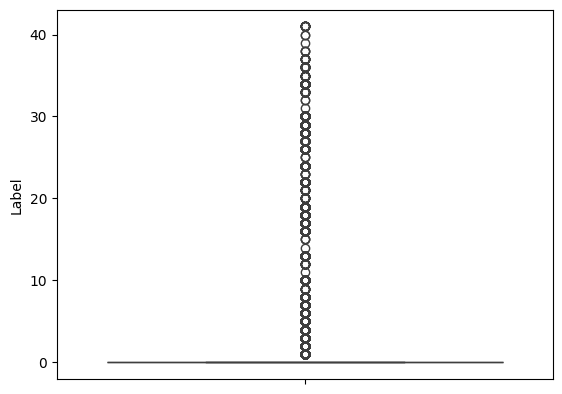

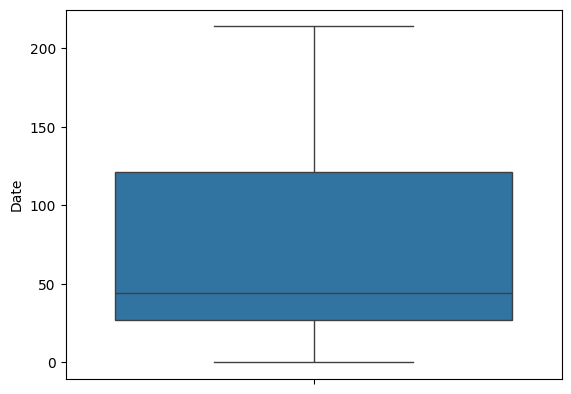

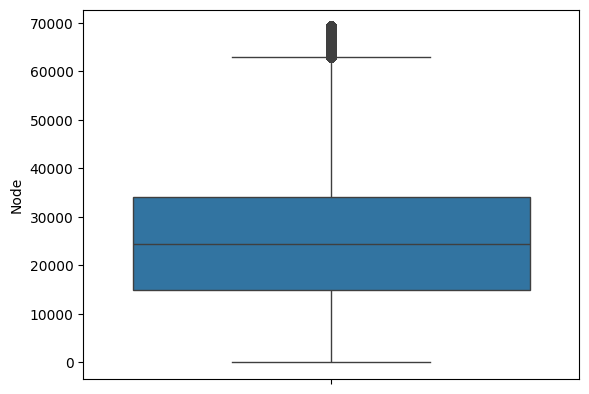

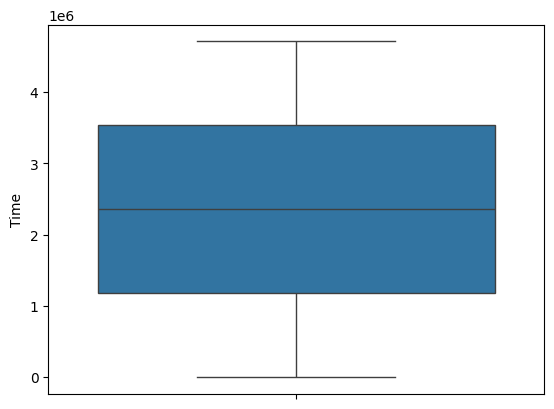

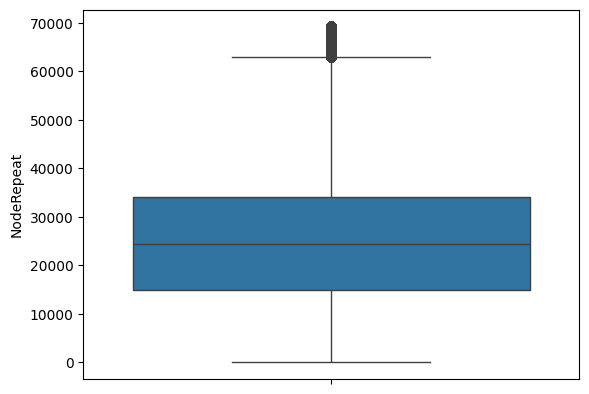

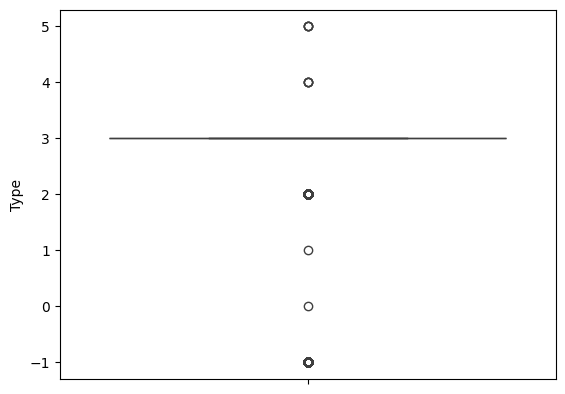

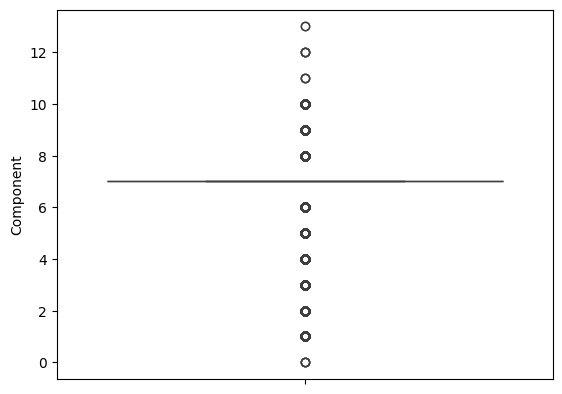

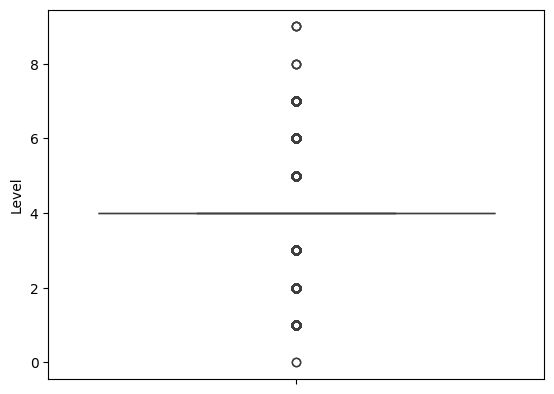

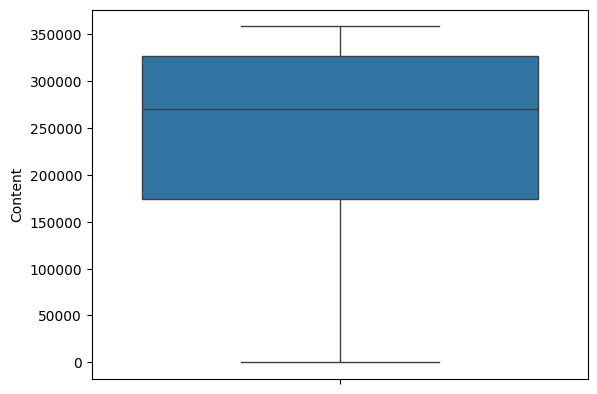

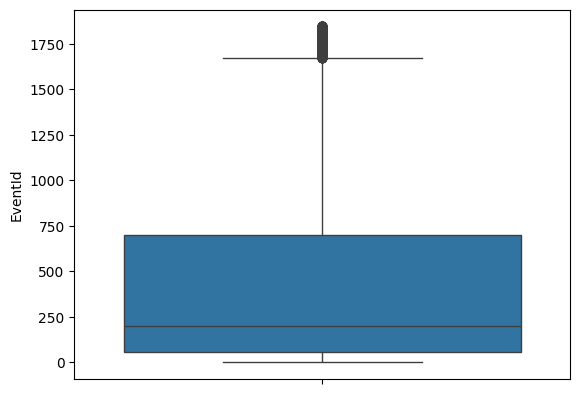

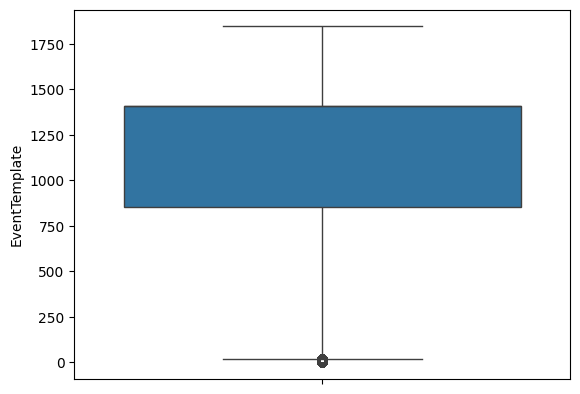

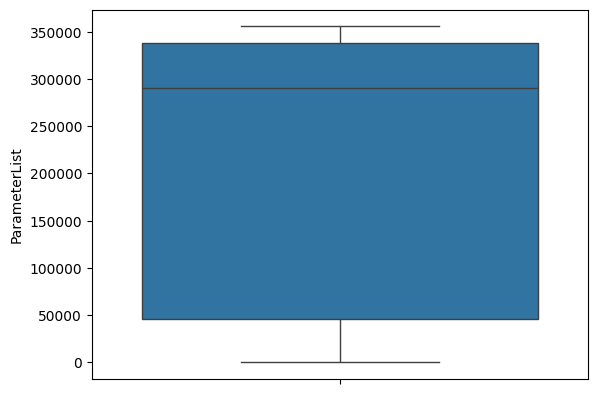

In [ ]:
# BoxPlot
for i in logs_cat.columns:
    # Conversion des catégories en valeurs numériques
    dataset[i] = dataset[i].astype('category').cat.codes
    sns.boxplot(dataset[i])
    plt.show()

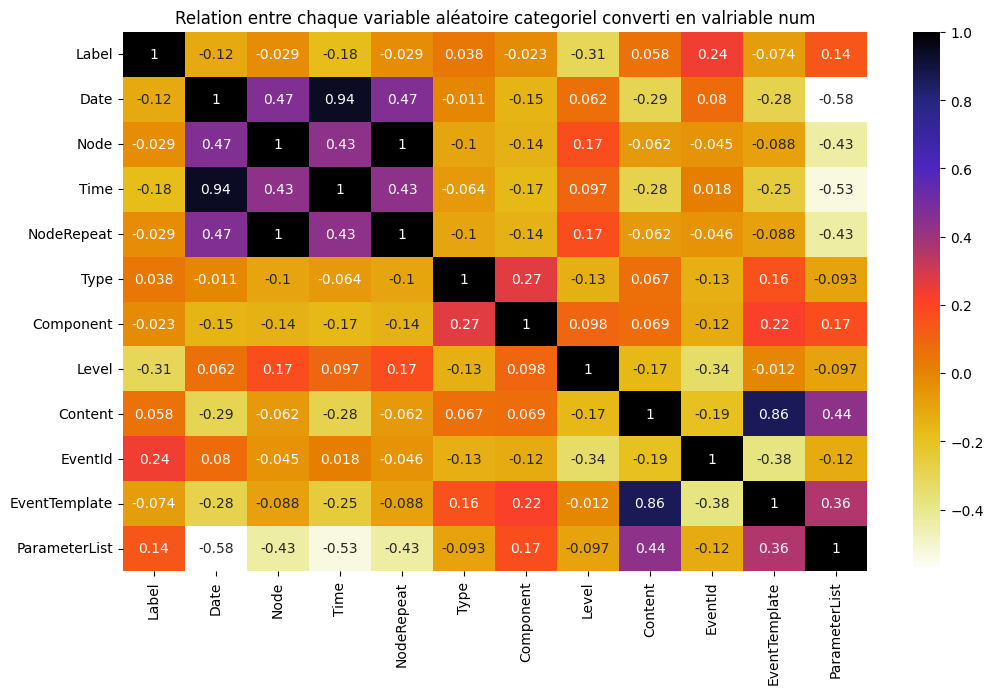

In [ ]:
# Affichage à l'aide d'une carte thermique de la corrélation entre les variables categoriel converti en variable numériques

import seaborn as sns
import matplotlib.pyplot as plt
logs_cat_num=logs_cat
plt.figure(figsize=(12, 7))
for i in logs_cat.columns:
    # Conversion des catégories en valeurs numériques
    logs_cat_num[i] = logs_cat_num[i].astype('category').cat.codes

cor = logs_cat_num.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.title('Relation entre chaque variable aléatoire categoriel converti en valriable num')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import IsolationForest


# Groupement des logs par date
grouped_logs = dataset.groupby('Date')
matrix_data = []

# Analyser les événements par type
critical_levels = []  # Niveaux de log critiques (ajuster si nécessaire)
non_alerts_label = '-'  # Balise pour les non-alertes

for date, group in grouped_logs:
    # Filtrer les messages d'alerte (exclure les non-alertes)
    critical_events = group[group['Label'] != non_alerts_label]

    # Compter les occurrences de chaque type d'événement
    event_counts = Counter(critical_events['EventId'].tolist())

    row_data = {'Date': date}
    row_data.update(event_counts)  # Ajouter les comptes des événements

    matrix_data.append(row_data)

In [ ]:

# Création du DataFrame final avec les événements
df_matrix = pd.DataFrame(matrix_data).fillna(0)

In [ ]:
# Appliquer un modèle de détection d'anomalies (par exemple, Isolation Forest)
# Remarque : Nous appliquons Isolation Forest sur les événements pour détecter des anomalies
features = df_matrix.drop(columns=['Date'])  # Utiliser uniquement les colonnes des événements

In [ ]:
# Initialiser Isolation Forest pour la détection d'anomalies
model = IsolationForest(contamination=0.05)  # Ajuster le taux de contamination (anomalies)
df_matrix['anomalie'] = model.fit_predict(features)  # -1 pour anomalies, 1 pour normales

In [ ]:
# Ajouter la colonne "anomalie" au DataFrame final
df_matrix['anomalie'] = df_matrix['anomalie'].apply(lambda x: 1 if x == -1 else 0)

In [ ]:
# Renommer les colonnes des événements
event_columns = [col for col in df_matrix.columns if col not in ['Date', 'anomalie']]
df_matrix.rename(columns={col: f'E{i+1}' for i, col in enumerate(event_columns)}, inplace=True)

In [ ]:
# Déplacer la colonne 'anomalie' à la dernière position
cols = [col for col in df_matrix.columns if col != 'anomalie'] + ['anomalie']
df_matrix = df_matrix[cols]

In [ ]:
# Afficher la matrice résultante
print(df_matrix.head())

         Date      E1     E2   E3    E4   E5   E6   E7   E8   E9  ...  E49  \
0  2005.06.03     0.0    0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1  2005.06.04  2040.0    0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2  2005.06.05     0.0  477.0  1.0  91.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3  2005.06.06     0.0    0.0  0.0   5.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
4  2005.06.07     0.0    0.0  0.0   4.0  1.0  0.0  0.0  0.0  0.0  ...  0.0   

   E50  E51  E52  E53  E54  E55  E56  E57  anomalie  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         0  

[5 rows x 59 columns]


In [ ]:
df_matrix.head()

NameError: name 'df_matrix' is not defined

In [ ]:
# Sauvegarder la matrice structurée dans un fichier CSV
df_matrix.to_csv('BGL_anomalies_matrix.csv', index=False)

# **Partie 4. Prédiction  des alerts**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np

# Load the data
df = pd.read_csv('BGL_anomalies_matrix.csv')

In [ ]:
# Vérifiez que les colonnes sont correctement formatées
# Assurez-vous que la colonne 'Date' est bien en format datetime si nécessaire
# df['Date'] = pd.to_datetime(df['Date'])

# Divisez les données en 60% entraînement, 20% validation, 20% test
train_size = int(0.60 * len(df))
val_size = int(0.20 * len(df))
test_size = len(df) - train_size - val_size

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]


In [ ]:
# Séparation des caractéristiques et de la cible
X_train = train_df.drop(columns=['Date', 'anomalie'])
y_train = train_df['anomalie'].astype(int)
X_val = val_df.drop(columns=['Date', 'anomalie'])
y_val = val_df['anomalie'].astype(int)
X_test = test_df.drop(columns=['Date', 'anomalie'])
y_test = test_df['anomalie'].astype(int)

In [ ]:
# Éliminer les corrélations
correlation_matrix = X_train.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
X_train = X_train.drop(columns=highly_correlated_features)
X_val = X_val.drop(columns=highly_correlated_features)
X_test = X_test.drop(columns=highly_correlated_features)

In [ ]:
# Entraînement du modèle Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


In [ ]:
# Entraînement du modèle Logistic Regression
lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

In [ ]:
# Fonction d'évaluation
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    auc = roc_auc_score(y_true, y_pred)

    print(f"Performance of {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC: {auc:.4f}")
    print('-' * 30)
    return auc, precision, recall

In [ ]:
# Évaluation des modèles sur le jeu de test
auc_rf, precision_rf, recall_rf = evaluate_model(y_test, rf_pred, "Random Forest")
auc_lr, precision_lr, recall_lr = evaluate_model(y_test, lr_pred, "Logistic Regression")


Performance of Random Forest:
Accuracy: 0.9767
Precision: 1.0000
Recall: 0.0000
AUC: 0.5000
------------------------------
Performance of Logistic Regression:
Accuracy: 0.9767
Precision: 1.0000
Recall: 0.0000
AUC: 0.5000
------------------------------


In [ ]:
# Choix du modèle le plus performant
if auc_rf > auc_lr:
    print("Le modèle Random Forest est le plus performant.")
else:
    print("Le modèle Logistic Regression est le plus performant.")

Le modèle Logistic Regression est le plus performant.
